In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import fer.data as fecdata
from pathlib import Path
import torch.nn.functional as F
device = 'cuda:1'

In [3]:
df = fecdata.pac_to_pac_transactions()
dataset, df, labelers = fecdata.prepare(df)

In [4]:
from fer.model import Config, FECEncoder, TabDataset, TabularDenoiser
import torch

cfg = Config(
    embedding_init_std=1e-4,
    tied_encoder_decoder_emb=True,
)
lr = 5e-4
n_epochs = 4
model = TabularDenoiser(
    cfg,
    n_entities=max(dataset["src"].max(), dataset["dst"].max()) + 1,
    n_etype=dataset["etype"].max() + 1,
    n_ttype=dataset["ttype"].max() + 1,
)
tds = TabDataset(dataset)

Non-A100 GPU detected, using math or mem efficient attention if input tensor is on cuda


In [5]:
from torch.utils.data import DataLoader, random_split
model = model.to(device)
model = torch.compile(model)

In [6]:
splitgen = torch.Generator().manual_seed(41)
batch_size=3000    
train_set, val_set = random_split(tds, [0.9, 0.1], generator=splitgen)
tdl = DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    num_workers=8,
    #persistent_workers=True,
)
vdl = DataLoader(
    val_set,
    batch_size=batch_size,
    shuffle=False,
    num_workers=8,
    #persistent_workers=True,
)

In [7]:
import torch.optim.lr_scheduler as lrsched
import math

optimizer = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=lr,
)
class WarmupConstantSchedule(lrsched.LambdaLR):
    """ Linear warmup and then constant.
        Linearly increases learning rate schedule from 0 to 1 over `warmup_steps` training steps.
        Keeps learning rate schedule equal to 1. after warmup_steps.
    """
    def __init__(self, optimizer, warmup_steps, last_epoch=-1):
        self.warmup_steps = warmup_steps
        super(WarmupConstantSchedule, self).__init__(optimizer, self.lr_lambda, last_epoch=last_epoch)

    def lr_lambda(self, step):
        if step < self.warmup_steps:
            return float(step) / float(max(1.0, self.warmup_steps))
        return 1.

class WarmupCosineSchedule(lrsched.LambdaLR):
    """ Linear warmup and then cosine decay.
        Linearly increases learning rate from 0 to 1 over `warmup_steps` training steps.
        Decreases learning rate from 1. to 0. over remaining `t_total - warmup_steps` steps following a cosine curve.
        If `cycles` (default=0.5) is different from default, learning rate follows cosine function after warmup.
    """
    def __init__(self, optimizer, warmup_steps, t_total, cycles=.5, last_epoch=-1):
        self.warmup_steps = warmup_steps
        self.t_total = t_total
        self.cycles = cycles
        super(WarmupCosineSchedule, self).__init__(optimizer, self.lr_lambda, last_epoch=last_epoch)

    def lr_lambda(self, step):
        if step < self.warmup_steps:
            return float(step) / float(max(1.0, self.warmup_steps))
        # progress after warmup
        progress = float(step - self.warmup_steps) / float(max(1, self.t_total - self.warmup_steps))
        return max(0.0, 0.5 * (1. + math.cos(math.pi * float(self.cycles) * 2.0 * progress)))
scheduler = WarmupCosineSchedule(optimizer, 1000, t_total=len(tdl) * n_epochs)

In [8]:
from fer.multitask import CoVWeightingLoss, UncertaintyWeightedLoss
n_losses = 15
# lossweighter = CoVWeightingLoss(n_losses)
lossweighter = UncertaintyWeightedLoss(n_losses)

In [9]:
from tqdm.notebook import tqdm
import wandb
from dataclasses import asdict

In [10]:
dtsks = sorted(k for k in dataset.keys() if k.startswith('scaled_dt_'))
def decoder_loss(encoded, batch):
    srclogits, dstlogits, etlogits, ttlogits, amtd, amtpos, dt_pred = model.decoder(encoded, model.encoder)
    srcloss = F.cross_entropy(srclogits, batch['src'].squeeze())
    dstloss = F.cross_entropy(dstlogits, batch['dst'].squeeze())
    etloss = F.cross_entropy(etlogits, batch['etype'].squeeze())
    ttloss = F.cross_entropy(ttlogits, batch['ttype'].squeeze())
    amtloss = F.mse_loss(amtd, batch['amt'])
    amtposloss = F.binary_cross_entropy_with_logits(amtpos, batch['amt_pos'].to(torch.float))
    #print(dt_pred.shape)
    dt_targets = torch.cat([batch[k].squeeze(dim=1) for k in dtsks], dim=1)
    #print(dt_targets.shape)
    dt_loss = F.mse_loss(dt_pred, dt_targets) 
    return dict(srcloss=srcloss,dstloss=dstloss,etloss=etloss,ttloss=ttloss,amtloss=amtloss,amtposloss=amtposloss,dt_loss=dt_loss)

In [11]:
wandb.init(project='fecentrep2', config=dict(lr=lr, **asdict(cfg)))
for epoch in range(n_epochs):
    with tqdm(tdl) as t:
        for i, batch in enumerate(t):
            batch = {k:v.to(device) for k,v in batch.items()}
            model.zero_grad()
            orig, corrupted, recovered = model(batch)
            enclosses = decoder_loss(orig, batch)
            reclosses = decoder_loss(recovered, batch)
            distloss = F.mse_loss(orig, recovered)
            # margin = 0.1
            # ocdiff = (orig != corrupted).max(dim=2).values.max(dim=0).values.float()
            # rec_corrupt_err = ((recovered-corrupted).pow(2).mean(dim=2).mean(dim=0) * ocdiff).sum() / ocdiff.sum()
            # repel_loss = F.relu(margin - rec_corrupt_err)
            all_losses = {}
            all_losses.update({f'enc/{k}': v for k,v in enclosses.items()})
            all_losses.update({f'rec/{k}': v for k,v in reclosses.items()})
            all_losses['dist_loss'] = distloss
            # all_losses['repel_loss'] = repel_loss
            weighted_loss = lossweighter.forward([lv for _, lv in sorted(all_losses.items())])
            total_loss = weighted_loss
            all_losses['total_loss'] = total_loss
            wandb.log(dict(**all_losses, lr=scheduler.get_last_lr()[0]))
            total_loss.backward()
            t.set_postfix(dict(loss=str(total_loss)))
            optimizer.step()
            scheduler.step()

wandb: Currently logged in as: apage43. Use `wandb login --relogin` to force relogin


  0%|          | 0/1057 [00:00<?, ?it/s]

[2023-07-29 21:09:36,588] torch._inductor.utils: [WARNING] using triton random, expect difference from eager
[2023-07-29 21:09:38,321] torch._inductor.utils: [WARNING] using triton random, expect difference from eager
[2023-07-29 21:09:39,289] torch._inductor.utils: [WARNING] using triton random, expect difference from eager
[2023-07-29 21:09:40,330] torch._inductor.utils: [WARNING] using triton random, expect difference from eager
[2023-07-29 21:09:40,975] torch._inductor.utils: [WARNING] using triton random, expect difference from eager
[2023-07-29 21:09:41,620] torch._inductor.utils: [WARNING] using triton random, expect difference from eager
[2023-07-29 21:09:42,259] torch._inductor.utils: [WARNING] using triton random, expect difference from eager
[2023-07-29 21:09:42,934] torch._inductor.utils: [WARNING] using triton random, expect difference from eager
[2023-07-29 21:09:43,604] torch._inductor.utils: [WARNING] using triton random, expect difference from eager
[2023-07-29 21:09:4

  0%|          | 0/1057 [00:00<?, ?it/s]

  0%|          | 0/1057 [00:00<?, ?it/s]

  0%|          | 0/1057 [00:00<?, ?it/s]

In [12]:
wandb.finish()

dist_loss,█████▇▆▆▅▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
enc/amtloss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
enc/amtposloss,█▇▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
enc/dstloss,███████▇▇▆▅▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
enc/dt_loss,█▅▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
enc/etloss,████▇▇▅▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
enc/srcloss,██████▇▇▇▆▅▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
enc/ttloss,█████▇▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr,▁▂▃▄▄▅▆▆▇██████▇▇▇▇▆▆▆▅▅▄▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁
rec/amtloss,█▆▅▃▃▂▃▂▂▂▂▂▁▂▁▂▂▂▂▁▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▂
rec/amtposloss,█▆▆▃▃▃▄▂▃▂▃▂▂▂▂▂▂▁▂▂▂▂▂▂▂▂▁▁▁▁▂▁▁▂▁▂▁▁▁▁


In [13]:
from umap import UMAP
import umap.plot as upl

/home/helly/repo/fer2/venv/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/helly/repo/fer2/venv/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/helly/repo/fer2/venv/lib/python3.10/site-packages/umap/distances.py:1086: NumbaD

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
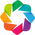

In [14]:
import holoviews as hv
hv.extension('bokeh')

In [15]:
entemb = model.encoder.entity_embeddings.weight.detach().cpu().numpy()
entemb.shape

(17567, 256)

In [16]:
uop = UMAP(verbose=True, min_dist=0.01)

In [17]:
e2d = uop.fit_transform(entemb)

UMAP(min_dist=0.01, verbose=True)
Sat Jul 29 21:39:30 2023 Construct fuzzy simplicial set
Sat Jul 29 21:39:30 2023 Finding Nearest Neighbors
Sat Jul 29 21:39:30 2023 Building RP forest with 12 trees
Sat Jul 29 21:39:34 2023 NN descent for 14 iterations
	 1  /  14
	 2  /  14
	 3  /  14
	 4  /  14
	 5  /  14
	 6  /  14
	Stopping threshold met -- exiting after 6 iterations
Sat Jul 29 21:39:55 2023 Finished Nearest Neighbor Search
Sat Jul 29 21:39:58 2023 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

Sat Jul 29 21:40:10 2023 Finished embedding


In [18]:
import pandas as pd
id2cid = labelers['id_labeler'].encoder.classes_
idorder = pd.DataFrame({'CMTE_ID':id2cid})
eframe = pd.DataFrame(e2d, columns=['x', 'y'])

In [19]:
def read_frame(header_file, data_file, dtypes={}):
    header = pd.read_csv(header_file)
    dt = {c: str for c in header.columns}
    dt.update(dtypes)
    data = pd.read_csv(data_file, sep="|", names=header.columns, dtype=dt)
    return data

def read_cm(year, basedir='./data'):
    cm = read_frame(
        f"{basedir}/cm_header_file.csv",
        f"{basedir}/{year}/cm.txt",
        dtypes={
            c: "str"
            for c in (
                "CMTE_DSGN",
                "CMTE_TP",
                "CMTE_PTY_AFFILIATION",
                "CMTE_FILING_FREQ",
            )
        },
    )
    return cm

cmdf = idorder.join(pd.concat([read_cm(2020), read_cm(2022), read_cm(2024)]).drop_duplicates(subset=['CMTE_ID'], keep='last').set_index('CMTE_ID'), on='CMTE_ID')

In [20]:
sz=450
(hv.Points(eframe.join(cmdf)).opts(width=sz, height=sz, color='CMTE_PTY_AFFILIATION', cmap='Category20') + 
 hv.Points(eframe.join(cmdf)).opts(width=sz, height=sz, color='CMTE_DSGN', cmap='Category20') + 
 hv.Points(eframe.join(cmdf)).opts(width=sz, height=sz, color='CMTE_TP', cmap='Category20') +
 hv.Points(eframe.join(cmdf)).opts(width=sz, height=sz, color='ORG_TP', cmap='Category20')).cols(2)

:Layout
   .Points.I   :Points   [x,y]   (CMTE_ID,CMTE_NM,TRES_NM,CMTE_ST1,CMTE_ST2,CMTE_CITY,CMTE_ST,CMTE_ZIP,CMTE_DSGN,CMTE_TP,CMTE_PTY_AFFILIATION,CMTE_FILING_FREQ,ORG_TP,CONNECTED_ORG_NM,CAND_ID)
   .Points.II  :Points   [x,y]   (CMTE_ID,CMTE_NM,TRES_NM,CMTE_ST1,CMTE_ST2,CMTE_CITY,CMTE_ST,CMTE_ZIP,CMTE_DSGN,CMTE_TP,CMTE_PTY_AFFILIATION,CMTE_FILING_FREQ,ORG_TP,CONNECTED_ORG_NM,CAND_ID)
   .Points.III :Points   [x,y]   (CMTE_ID,CMTE_NM,TRES_NM,CMTE_ST1,CMTE_ST2,CMTE_CITY,CMTE_ST,CMTE_ZIP,CMTE_DSGN,CMTE_TP,CMTE_PTY_AFFILIATION,CMTE_FILING_FREQ,ORG_TP,CONNECTED_ORG_NM,CAND_ID)
   .Points.IV  :Points   [x,y]   (CMTE_ID,CMTE_NM,TRES_NM,CMTE_ST1,CMTE_ST2,CMTE_CITY,CMTE_ST,CMTE_ZIP,CMTE_DSGN,CMTE_TP,CMTE_PTY_AFFILIATION,CMTE_FILING_FREQ,ORG_TP,CONNECTED_ORG_NM,CAND_ID)

In [21]:
def do_atlas(do_norm=True):
    from nomic import atlas
    from sklearn.preprocessing import normalize
    
    do_norm = True
    atlas.map_embeddings(
        normalize(entemb) if do_norm else entemb,
        data=eframe.join(cmdf).drop(columns=['x','y']),
        name='fecentrep-2' + ('-norm' if do_norm else ''),
        colorable_fields=['CMTE_TP', 'CMTE_DSGN', 'ORG_TP', 'CMTE_PTY_AFFILIATION'],
        id_field='CMTE_ID',
        topic_label_field='CMTE_NM',
        reset_project_if_exists=True,
    )

In [ ]:
# do_atlas()